## Configuração de Ambiente

## Importação de Dados

In [ ]:
!pip uninstall -y numpy spacy thinc
!pip install spacy --upgrade
!pip install lftk
!python -m spacy download pt_core_news_sm

In [ ]:
import pandas as pd
import spacy
import lftk
from tqdm import tqdm

folder_path = 'data/'

from google.colab import drive

drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/red_pill_analises/'
caminho_dados_limpos = 'data_base/resultados/'

#df_comments = pd.read_csv(folder_path + caminho_dados_limpos + 'comentarios_com_lftk.csv')
df_videos = pd.read_csv(folder_path + caminho_dados_limpos + 'videos_limpos.csv')

# Ativa tqdm para pandas
tqdm.pandas()

In [ ]:
# -*- coding: utf-8 -*-
"""lftk.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1RsU6siDu4b6k3WEPm9Nfb23tNhDJZTtU

## Configuração de Ambiente

## Importação de Dados
"""

import pandas as pd
import spacy
import lftk
from tqdm import tqdm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_path = 'data/'

nlp = spacy.load("pt_core_news_sm")

In [ ]:
# 4. Função que aplica o LFTK e retorna apenas as features necessárias
def extract_selected_features(text):
    required_features = [
        'fkgl', 'fogi', 'smog',                      # legibilidade
        'uber_ttr',                                  # diversidade lexical
        'a_word_ps', 'a_syll_pw',                    # tamanho de palavras e sentenças
        'a_kup_pw', 'a_bry_pw', 'a_subtlex_us_zipf_pw',  # raridade
        'a_n_ent_ps'                                 # entidades
    ]
    doc = nlp(text)
    extractor = lftk.Extractor(docs=doc)
    features = extractor.extract(features=required_features)
    return features

def pipe(df, tipo):
    print(f"INICIANDO PIPE PARA {tipo}")
    print(len(df))

    # Garante que os dados estão ordenados corretamente (opcional)
    df = df.sort_values(['id_canal_anonimizado', 'like_count'])  # ou pela coluna de data, se existir

    # 1. Filtra textos válidos
    df_valid = df[df['text'].apply(lambda x: isinstance(x, str) and len(x.strip()) > 10)].copy()

    # Ativa tqdm para pandas
    tqdm.pandas()

    # 2. Carrega o modelo spaCy em português
    nlp = spacy.load("pt_core_news_sm")

    # 3. Define as features necessárias
    required_features = [
        'fkgl', 'fogi', 'smog',                      # legibilidade
        'uber_ttr',                                  # diversidade lexical
        'a_word_ps', 'a_syll_pw',                    # tamanho de palavras e sentenças
        'a_kup_pw', 'a_bry_pw', 'a_subtlex_us_zipf_pw',  # raridade
        'a_n_ent_ps'                                 # entidades
    ]

    # 5. Aplica para cada texto com barra de progresso
    features_list = df_valid['text'].progress_apply(extract_selected_features)

    # 6. Converte para DataFrame
    features_df = pd.json_normalize(features_list)

    # 7. Concatena com os dados originais
    df_valid = pd.concat([df_valid.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

    df_valid.to_csv(folder_path + "featured.csv")

    # 8. Calcula métricas agregadas
    df_valid['grade_level_avg'] = df_valid[['fkgl', 'fogi', 'smog']].mean(axis=1)
    df_valid['lexical_diversity'] = df_valid['uber_ttr']
    df_valid['words_per_sentence'] = df_valid['a_word_ps']
    df_valid['syllables_per_word'] = df_valid['a_syll_pw']
    df_valid['rarity_avg'] = df_valid[['a_kup_pw', 'a_bry_pw', 'a_subtlex_us_zipf_pw']].mean(axis=1)
    df_valid['entities_per_sentence'] = df_valid['a_n_ent_ps']

    # 9. Lista de métricas
    metric_cols = [
        'grade_level_avg',
        'lexical_diversity',
        'words_per_sentence',
        'syllables_per_word',
        'rarity_avg',
        'entities_per_sentence'
    ]

    # Cria coluna de legibilidade média baseada nos índices educacionais
    df_valid['grade_level_avg'] = df_valid[['fkgl', 'fogi', 'smog']].mean(axis=1)

    # Diversidade lexical
    df_valid['lexical_diversity'] = df_valid['uber_ttr']

    # Comprimento médio de sentenças e palavras
    df_valid['words_per_sentence'] = df_valid['a_word_ps']
    df_valid['syllables_per_word'] = df_valid['a_syll_pw']

    # Frequência média de palavras raras (menos frequentes)
    df_valid['rarity_avg'] = df_valid[['a_kup_pw', 'a_bry_pw', 'a_subtlex_us_zipf_pw']].mean(axis=1)

    # Número de entidades por sentença
    df_valid['entities_per_sentence'] = df_valid['a_n_ent_ps']

    # Agrupa por canal
    df_valid.to_csv(f'{tipo}_com_lftk.csv')

    return df_valid

df_videos_com_lftk = pipe(df_videos, tipo='videos')
#df_comments_com_lftk = pipe(df_comments, tipo='comentarios')


## Plotar gráficos com dados já calculados

In [4]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/red_pill_analises/'
caminho_dados_limpos = 'data_base/resultados/'

#df_comments = pd.read_csv(folder_path + caminho_dados_limpos + 'comentarios_com_lftk.csv')
df_videos_com_lftk = pd.read_csv(folder_path + caminho_dados_limpos + 'videos_com_lftk.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-3736154316.py:9: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_videos_com_lftk = pd.read_csv(folder_path + caminho_dados_limpos + 'videos_com_lftk.csv')


In [5]:
df_valid = df_videos_com_lftk

### Gráfico de Barras

<Figure size 1500x800 with 0 Axes>

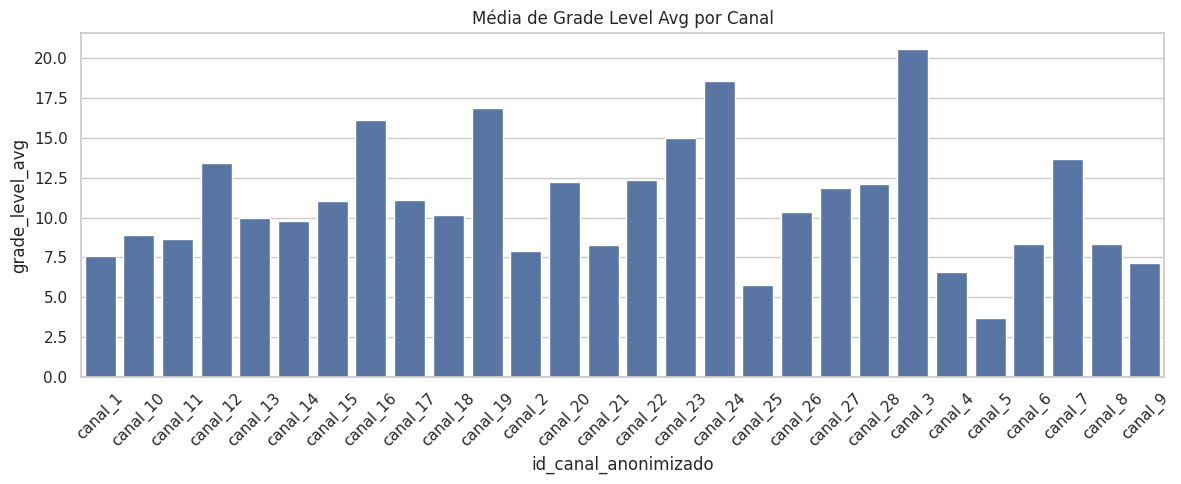

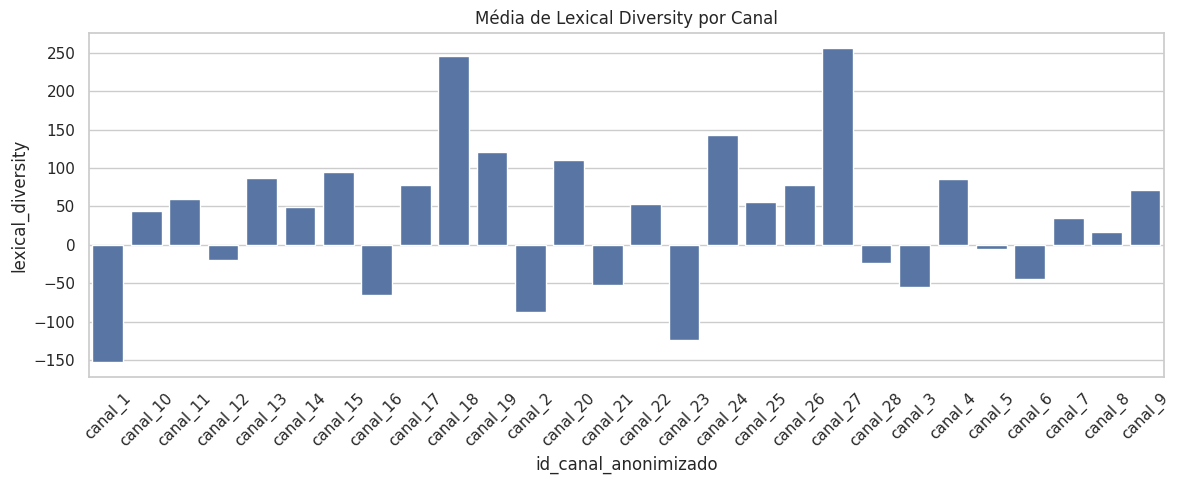

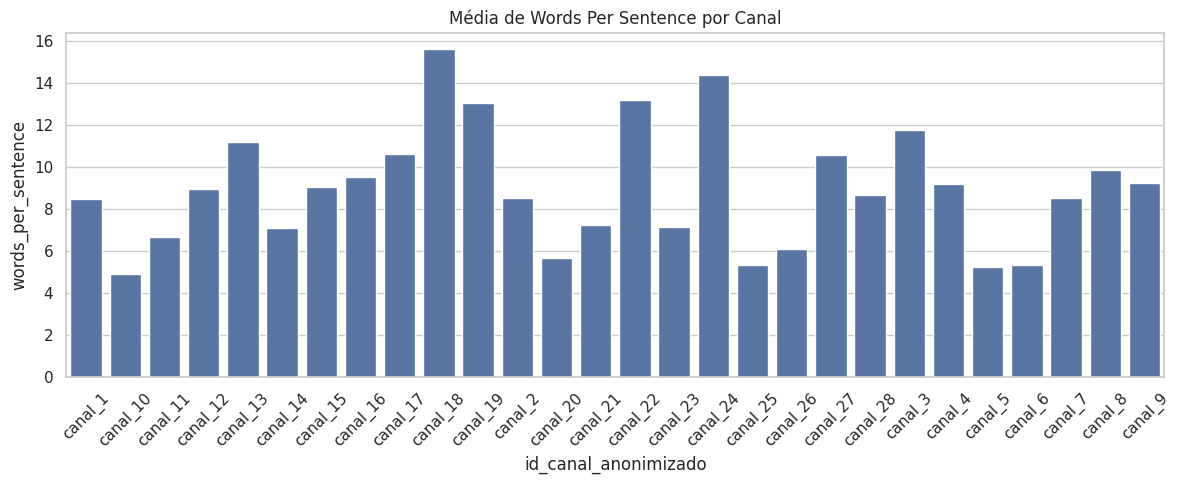

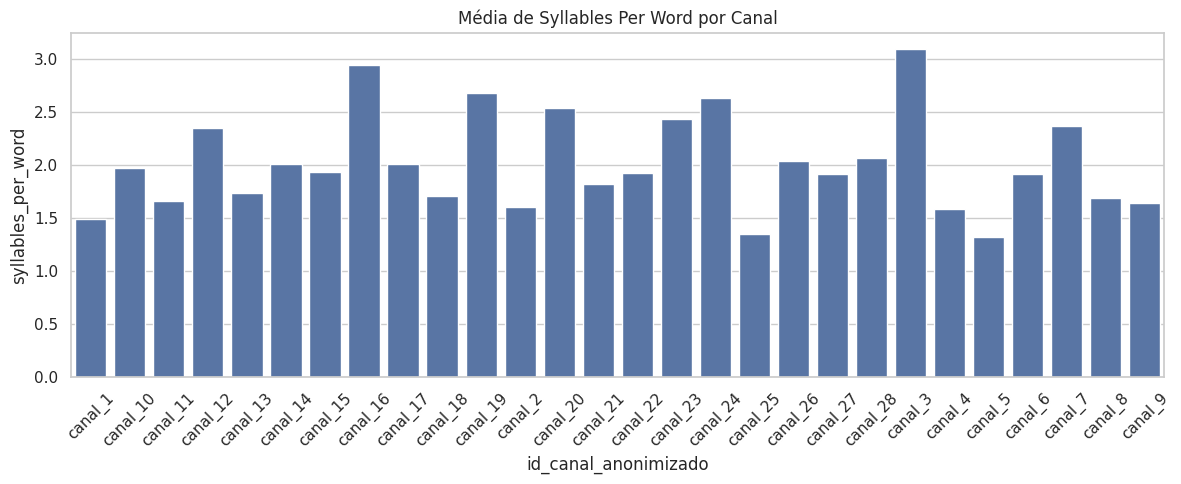

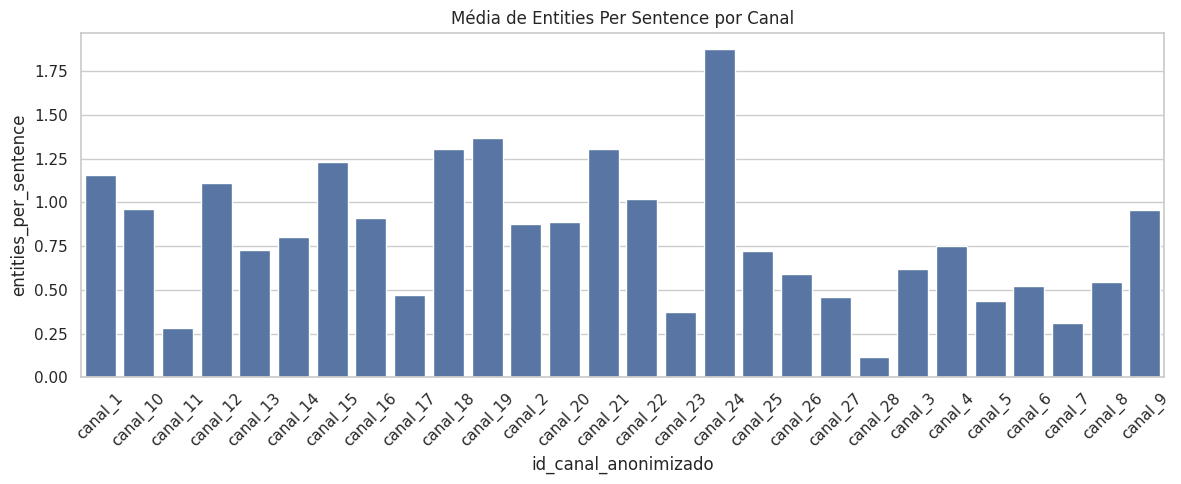

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define estilo
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

# Define as métricas
metric_cols = [
    'grade_level_avg', # Include grade_level_avg here
    'lexical_diversity',
    'words_per_sentence',
    'syllables_per_word',
    'entities_per_sentence'
]

# Ensure df_valid is available (assuming it's loaded from df_videos_com_lftk)
df_valid = df_videos_com_lftk

# Agrupa por canal
df_grouped = df_valid.groupby('id_canal_anonimizado')[metric_cols].mean().reset_index()

# Plot para cada métrica
for col in metric_cols:
    plt.figure(figsize=(12, 5))
    sns.barplot(x='id_canal_anonimizado', y=col, data=df_grouped)
    plt.xticks(rotation=45)
    plt.title(f'Média de {col.replace("_", " ").title()} por Canal')
    plt.tight_layout()
    plt.show()

### Primeiro Gráfico (não aparece no paper)

In [9]:
import numpy as np

# Estimativas auxiliares
df_valid['n_sentences'] = df_valid['a_word_ps'].apply(lambda x: np.nan if x == 0 else df_valid['a_word_ps'].mean())  # evitar divisão por zero
df_valid['n_words'] = df_valid['n_sentences'] * df_valid['a_word_ps']
df_valid['n_syllables'] = df_valid['n_words'] * df_valid['a_syll_pw']
df_valid['n_letters'] = df_valid['n_words'] * 4.7  # média de letras por palavra em inglês
df_valid['n_complex_words'] = df_valid['n_words'] * 0.15  # estimativa: 15% de palavras complexas

# 1. Flesch Reading Ease
df_valid['flesch_reading_ease'] = 226 \
    - 1.04 * (df_valid['n_words'] / df_valid['n_sentences']) \
    - 72 * (df_valid['n_syllables'] / df_valid['n_words'])

# 2. Gulpease Index (adaptado para português, normalmente não se usa em inglês)
df_valid['gulpease'] = 89 + ((300 * df_valid['n_sentences']) - (10 * df_valid['n_letters'])) / df_valid['n_words']

# 3. Flesch-Kincaid Grade Level
df_valid['flesch_kincaid_grade'] = 0.36 * (df_valid['n_words'] / df_valid['n_sentences']) \
    + 10.4 * (df_valid['n_syllables'] / df_valid['n_words']) - 18

# 4. Gunning Fog Index
df_valid['gunning_fog_index'] = 0.49 * (df_valid['n_words'] / df_valid['n_sentences']) \
    + 19 * (df_valid['n_complex_words'] / df_valid['n_words'])

# 5. Automated Readability Index (ARI)
df_valid['ari'] = 4.6 * (df_valid['n_letters'] / df_valid['n_words']) \
    + 0.44 * (df_valid['n_words'] / df_valid['n_sentences']) - 20

# 6. Coleman-Liau Index
df_valid['coleman_liau'] = 5.4 * (df_valid['n_letters'] / df_valid['n_words']) \
    - 21 * (df_valid['n_sentences'] / df_valid['n_words']) - 14

In [10]:
# Atualiza fonte
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 10,
    'axes.titlesize': 21,
    'axes.labelsize': 21,
    'xtick.labelsize': 18,
    'ytick.labelsize': 21,
    'legend.fontsize': 20,
})

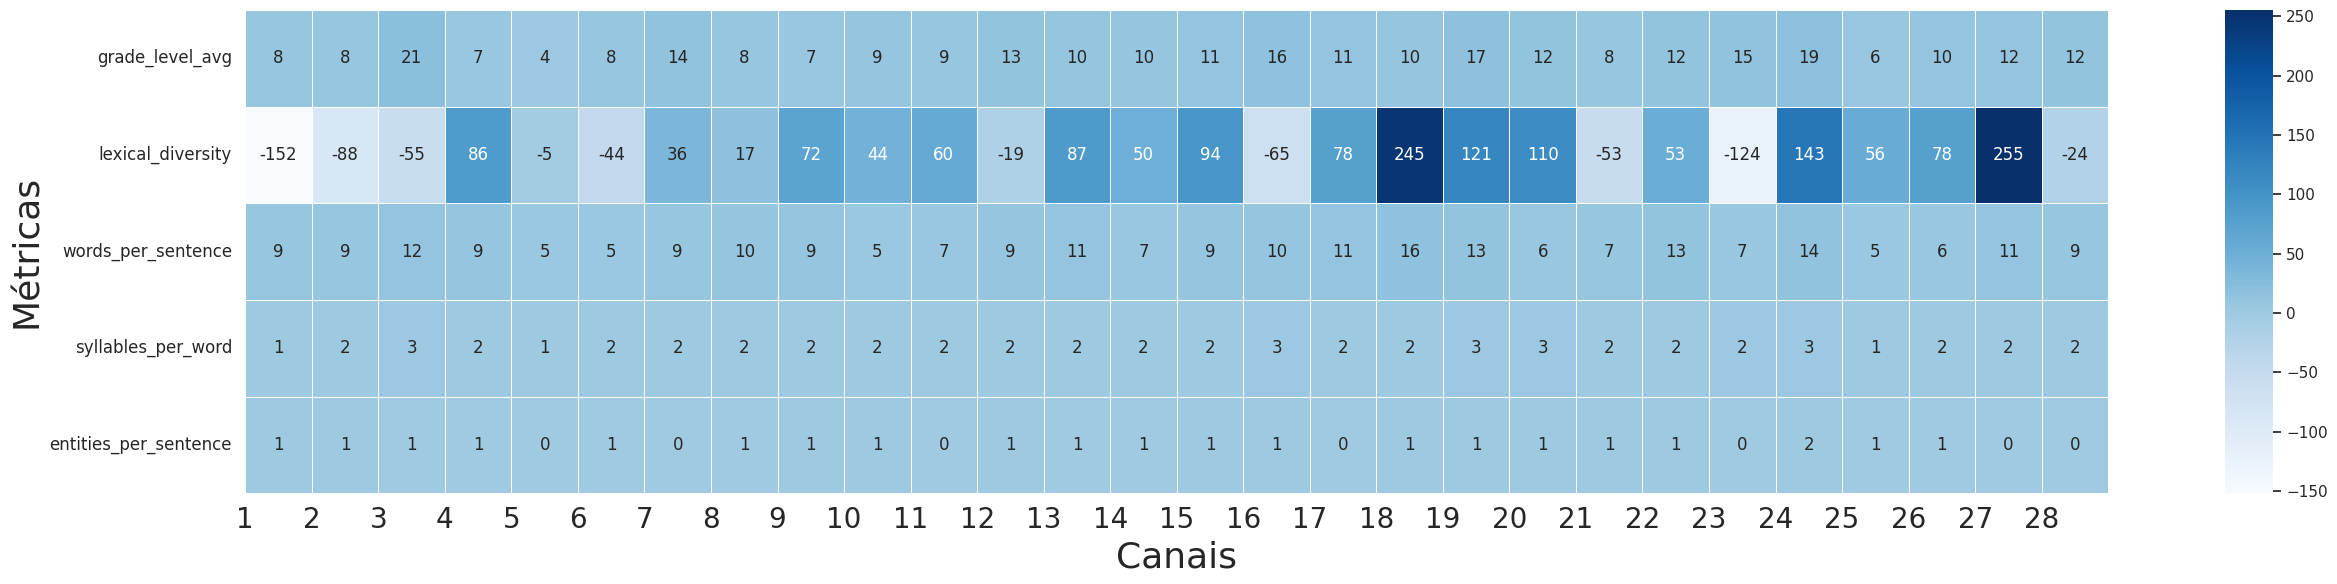

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Lista atualizada de métricas a serem agregadas
metric_cols = [
    'grade_level_avg',
    'lexical_diversity',
    'words_per_sentence',
    'syllables_per_word',
    'entities_per_sentence'
]

# Agrupa por canal
df_grouped = df_valid.groupby('id_canal_anonimizado')[metric_cols].mean().reset_index()

# Transforma: linhas = métricas, colunas = canais
df_heatmap = df_grouped.set_index('id_canal_anonimizado')[metric_cols].T

# Sort columns numerically by channel number
df_heatmap = df_heatmap[sorted(df_heatmap.columns, key=lambda x: int(x.split('_')[1]))]

# Normaliza por linha (métrica)
df_heatmap_normalized = df_heatmap.apply(lambda x: x)#(x - x.min()) / (x.max() - x.min()), axis=1)

# Cria o heatmap
plt.figure(figsize=(26, 6))
sns.heatmap(df_heatmap_normalized, cmap="Blues", annot=True, fmt=".0f", linewidths=.5, cbar_kws={'aspect': 10})

plt.yticks(rotation=0, fontsize=12)
plt.xticks(ticks=range(len(df_heatmap_normalized.columns)), labels=[col.split('_')[1] for col in df_heatmap_normalized.columns], rotation=0, ha="center", fontsize=20)
plt.ylabel("Métricas", fontsize=26)
plt.xlabel("Canais", fontsize=26)
plt.tight_layout()
plt.show()

In [83]:
# Group channels by their rounded average grade level
df_grouped['grade_level_avg_rounded'] = df_grouped['grade_level_avg'].round().astype(int)
channels_by_grade = df_grouped.groupby('grade_level_avg_rounded')['id_canal_anonimizado'].apply(list)

# Print the groups of channels with the same average grade level
print("\nCanais agrupados por Média de Grade Level arredondada:")
for grade, channels in channels_by_grade.items():
    print(f"Média de Grade Level {grade}: {channels}")


Canais agrupados por Média de Grade Level arredondada:
Média de Grade Level 4: ['canal_5']
Média de Grade Level 6: ['canal_25']
Média de Grade Level 7: ['canal_4', 'canal_9']
Média de Grade Level 8: ['canal_1', 'canal_2', 'canal_21', 'canal_6', 'canal_8']
Média de Grade Level 9: ['canal_10', 'canal_11']
Média de Grade Level 10: ['canal_13', 'canal_14', 'canal_18', 'canal_26']
Média de Grade Level 11: ['canal_15', 'canal_17']
Média de Grade Level 12: ['canal_20', 'canal_22', 'canal_27', 'canal_28']
Média de Grade Level 13: ['canal_12']
Média de Grade Level 14: ['canal_7']
Média de Grade Level 15: ['canal_23']
Média de Grade Level 16: ['canal_16']
Média de Grade Level 17: ['canal_19']
Média de Grade Level 19: ['canal_24']
Média de Grade Level 21: ['canal_3']


In [89]:
# Sort channels by lexical diversity in descending order
df_sorted_by_lexical_diversity = df_grouped.sort_values(by='lexical_diversity', ascending=False).reset_index(drop=True)

print("\nCanais ordenados por Diversidade Lexical (decrescente):")
display(df_sorted_by_lexical_diversity[['id_canal_anonimizado', 'lexical_diversity']])


Canais ordenados por Diversidade Lexical (decrescente):


,id_canal_anonimizado,lexical_diversity
0,canal_27,255.319875
1,canal_18,245.325084
2,canal_24,142.624503
3,canal_19,121.224791
4,canal_20,110.024491
5,canal_15,94.462099
6,canal_13,87.095200
7,canal_4,85.586817
8,canal_26,78.010327
9,canal_17,77.518588


In [88]:
print("\nCanais ordenados por Palavras por sentença (decrescente):")

# Cria uma cópia arredondada da coluna 'words_per_sentence' para exibir
df_sorted_by_words_per_sentence['words_per_sentence_rounded'] = df_sorted_by_words_per_sentence['words_per_sentence'].round().astype(int)

# Exibe só o canal e a coluna arredondada
display(df_sorted_by_words_per_sentence[['id_canal_anonimizado', 'words_per_sentence_rounded']])


Canais ordenados por Palavras por sentença (decrescente):


,id_canal_anonimizado,words_per_sentence_rounded
0,canal_18,16
1,canal_24,14
2,canal_22,13
3,canal_19,13
4,canal_3,12
5,canal_13,11
6,canal_17,11
7,canal_27,11
8,canal_8,10
9,canal_16,10


In [87]:
# Ordena canais por syllables_per_word em ordem decrescente
df_sorted_by_syllables_per_word = df_grouped.sort_values(by='syllables_per_word', ascending=False).reset_index(drop=True)

print("\nCanais ordenados por Syllables per Word (decrescente):")

# Cria uma coluna arredondada para exibir
df_sorted_by_syllables_per_word['syllables_per_word_rounded'] = df_sorted_by_syllables_per_word['syllables_per_word'].round().astype(int)

# Exibe só o canal e a coluna arredondada
display(df_sorted_by_syllables_per_word[['id_canal_anonimizado', 'syllables_per_word_rounded']])


Canais ordenados por Syllables per Word (decrescente):


,id_canal_anonimizado,syllables_per_word_rounded
0,canal_3,3
1,canal_16,3
2,canal_19,3
3,canal_24,3
4,canal_20,3
5,canal_23,2
6,canal_7,2
7,canal_12,2
8,canal_28,2
9,canal_26,2


In [91]:
# Ordena canais por entities_per_sentence em ordem decrescente
df_sorted_by_entities_per_sentence = df_grouped.sort_values(by='entities_per_sentence', ascending=False).reset_index(drop=True)

print("\nCanais ordenados por Entities per Word (decrescente):")

# Cria uma coluna arredondada para exibir
df_sorted_by_entities_per_sentence['entities_per_sentence_rounded'] = df_sorted_by_entities_per_sentence['entities_per_sentence'].round().astype(int)

# Exibe só o canal e a coluna arredondada
display(df_sorted_by_entities_per_sentence[['id_canal_anonimizado', 'entities_per_sentence_rounded']])


Canais ordenados por Entities per Word (decrescente):


,id_canal_anonimizado,entities_per_sentence_rounded
0,canal_24,2
1,canal_19,1
2,canal_18,1
3,canal_21,1
4,canal_15,1
5,canal_1,1
6,canal_12,1
7,canal_22,1
8,canal_10,1
9,canal_9,1


### Segundo Gráfico (usado no paper)

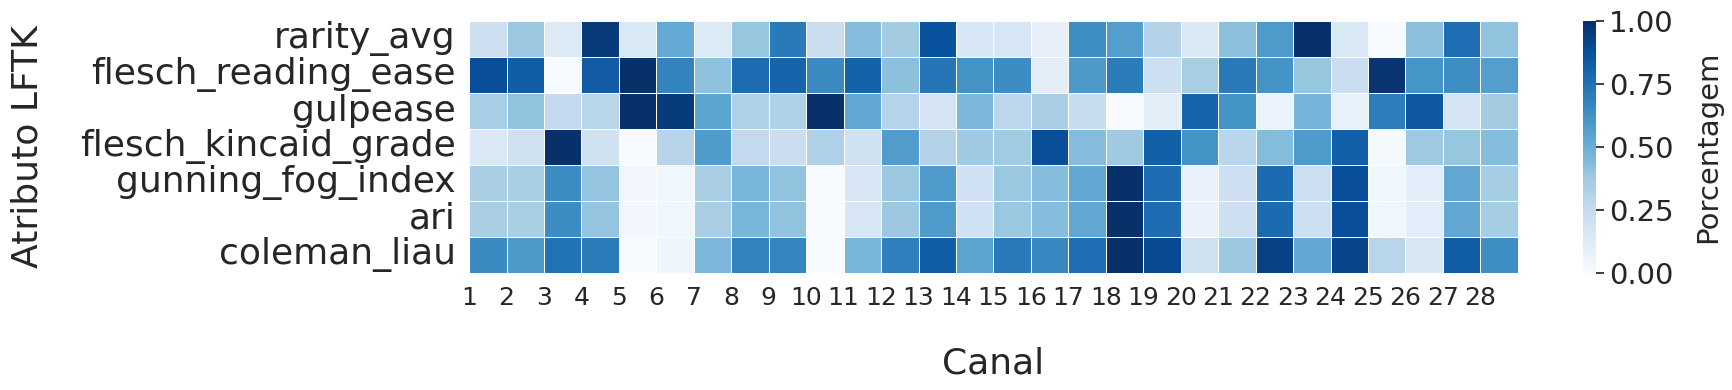

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Atualiza fonte
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 10,
    'axes.titlesize': 21,
    'axes.labelsize': 21,
    'xtick.labelsize': 18,
    'ytick.labelsize': 21,
    'legend.fontsize': 20,
})

# Lista atualizada de métricas a serem agregadas
metric_cols = [
    'rarity_avg',
    'flesch_reading_ease',
    'gulpease',
    'flesch_kincaid_grade',
    'gunning_fog_index',
    'ari',
    'coleman_liau'
]

# Agrupa por canal
df_grouped = df_valid.groupby('id_canal_anonimizado')[metric_cols].mean().reset_index()

# Transforma: linhas = métricas, colunas = canais
df_heatmap = df_grouped.set_index('id_canal_anonimizado')[metric_cols].T

# Sort columns numerically by channel number
df_heatmap = df_heatmap[sorted(df_heatmap.columns, key=lambda x: int(x.split('_')[1]))]

# Normaliza por linha (métrica)
df_heatmap_normalized = df_heatmap.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

# Cria o heatmap
plt.figure(figsize=(18, 4))
ax = sns.heatmap(df_heatmap_normalized, cmap="Blues", annot=False, fmt=".1f", linewidths=.5)

plt.yticks(rotation=0, fontsize=26)
plt.xticks(ticks=range(len(df_heatmap_normalized.columns)), labels=range(1, len(df_heatmap_normalized.columns) + 1), rotation=0, fontsize=18, ha='center')
plt.ylabel("Atributo LFTK", fontsize=26, labelpad=26)
plt.xlabel("Canal", fontsize=26, labelpad=26)

# Set colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label(f'Porcentagem', labelpad=15)


plt.tight_layout()
plt.show()

In [98]:
# Calculate the mean of each metric across all channels
average_metrics = df_grouped[metric_cols].mean().sort_values(ascending=False)

print("Média dos atributos em ordem decrescente:")
display(average_metrics)

Média dos atributos em ordem decrescente:


,0
gulpease,84.626985
flesch_reading_ease,71.515024
coleman_liau,8.396111
gunning_fog_index,7.252650
flesch_kincaid_grade,6.199350
ari,5.573400
rarity_avg,0.744887


## 🧠 Como interpretar
* Linhas: métricas linguísticas e de legibilidade.

* Colunas: canais do YouTube (e.g., canal_1, canal_10...).

* Cores: valores normalizados entre 0 (mais baixo, claro) e 1 (mais alto, escuro) dentro de cada métrica — ou seja, valores mais escuros indicam maior valor relativo daquela métrica em relação aos outros canais.

## 🔍 Interpretação por métrica:
1. grade_level_avg (média de FKGL, FOG, SMOG)
canal_20, canal_19 e canal_10 apresentam os textos mais complexos (maior escolaridade exigida).

canal_27, canal_28, canal_9 têm os textos mais simples.

2. lexical_diversity (diversidade vocabular)
canal_2, canal_19, canal_21 têm vocabulário mais variado.

canal_5, canal_6, canal_7 possuem vocabulário mais repetitivo.

3. words_per_sentence
Canais como canal_2, canal_19, canal_25 têm frases mais longas.

Frases mais curtas em canal_6, canal_7, canal_8.

4. syllables_per_word
Valores altos em canal_2, canal_20, canal_21 indicam palavras mais longas ou sofisticadas.

Mais simples em canal_6, canal_7, canal_9.

5. rarity_avg (raridade lexical: KUP, BRY, SUBTLEX)
Palavras mais raras: canal_20, canal_25, canal_13.

Palavras mais comuns: canal_6, canal_9.

6. entities_per_sentence
Textos mais "densos" em entidades (pessoas, lugares etc.): canal_10, canal_2.

Textos com menos entidades: canal_6, canal_7.

## 🔤 Métricas de legibilidade específicas:
7. flesch_reading_ease (quanto maior, mais fácil)
* canal_2, canal_12 têm leitura mais fácil.
* canal_10, canal_1 mais difíceis.

8. gulpease (adaptado para português — maior = mais fácil)
* canal_2, canal_12 mais fáceis de ler.
* canal_10, canal_1 mais difíceis.

9. flesch_kincaid_grade
* Mesma lógica do grade_level_avg.

10. gunning_fog_index
* Valores altos em canal_2, canal_20, canal_19 indicam textos mais nebulosos (complexos).

* Mais simples em canais com frases e vocabulário mais diretos (e.g. canal_6, canal_9).

11. ari (Automated Readability Index)
* Padrão semelhante ao anterior.

12. coleman_liau
* canal_10, canal_20, canal_25 são mais complexos por essa métrica.
* canal_6, canal_7 são mais simples.

## 📌 Conclusões gerais:
Canal	Perfil
* canal_2: Léxico sofisticado, frases longas, mais difícil de ler.
* canal_10:	Mais denso em entidades e complexo na maioria das métricas.
* canal_20:	Texto difícil e vocabulário mais raro e longo.
* canal_6, canal_7, canal_9:	Textos curtos, simples, com vocabulário básico.
* canal_12, canal_25:	Relativamente fáceis de ler, mas ainda com alguma sofisticação.